In [65]:
from functions import *

In [66]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns

## Load data

### Load rivers

In [ ]:
import fiona
import geopandas as gpd
from shapely.geometry import shape
source_folder = '../data/external/raster_masks'
rivers = {}
for subdir, dirs, files in os.walk(source_folder):
    for i,file in enumerate(files):
        r,m = load_raster(os.path.join(subdir, file), False)
        #rius = list(img_per_river.keys())
        name = file.split('.')[0].split('bw_')[-1]
        rivers[name] = r
rivers.keys()

dict_keys(['I_Custiell', 'le_boiron2', 'LaVenoge_shapefile', 'swissTLMboiron', 'Wasserfallenbach', 'Plattenbach', 'Aletenbach', 'Bisse-Neuf', 'Eibachli', 'Zauggenbach', 'Alplibach', 'La_Paudeze', 'LaBroye_shapefile'])

### Choose inputs

In [406]:
W = 256
filter_river = None#[3,11,12]
inputs = ['ndvi','discharge', 'slope']#, ndvi, disch, slope' #'lst+ndvi' for ndvi inputs
conditioned = False
batch_size = 4
epochs = 50

In [407]:
source_path = '../data/preprocessed/'
data_paths = ['lst', 'ndvi', 'wt', 'masked','discharge', 'slope']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k:[] for k in data_paths}

for i,dir_p in enumerate(dir_paths):
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints'): #and rivers_count < max_rivers:
            all_dir_paths[data_paths[i]].append(subdir)
        elif subdir.endswith('masked'):
            all_dir_paths['masked'].append(subdir)
       
all_dir_paths    

{'lst': ['../data/preprocessed/lst/Wasserfallenbach',
  '../data/preprocessed/lst/Eibachli',
  '../data/preprocessed/lst/Bisse-Neuf',
  '../data/preprocessed/lst/LaVenoge_shapefile',
  '../data/preprocessed/lst/le_boiron2',
  '../data/preprocessed/lst/I_Custiell',
  '../data/preprocessed/lst/La_Paudeze',
  '../data/preprocessed/lst/Zauggenbach',
  '../data/preprocessed/lst/Aletenbach',
  '../data/preprocessed/lst/Alplibach',
  '../data/preprocessed/lst/Plattenbach',
  '../data/preprocessed/lst/swissTLMboiron',
  '../data/preprocessed/lst/LaBroye_shapefile'],
 'ndvi': ['../data/preprocessed/ndvi/Wasserfallenbach',
  '../data/preprocessed/ndvi/Eibachli',
  '../data/preprocessed/ndvi/Bisse-Neuf',
  '../data/preprocessed/ndvi/LaVenoge_shapefile',
  '../data/preprocessed/ndvi/le_boiron2',
  '../data/preprocessed/ndvi/I_Custiell',
  '../data/preprocessed/ndvi/La_Paudeze',
  '../data/preprocessed/ndvi/Zauggenbach',
  '../data/preprocessed/ndvi/Aletenbach',
  '../data/preprocessed/ndvi/Alpliba

In [408]:
total_data = {}
total_times = {}

for k,v in all_dir_paths.items():
    if filter_river != None:
        v = [v[i] for i in filter_river]
    print('getting data for path',v) 

    if k != 'discharge' and k != 'slope':
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)

            labels = []
            for ki,value in data.items():
                labels+=[ki.split('/')[-1]]*len(value)
                
        

        
        data, times = load_data(v,W,list_rgb)
        

        total_data[k] = np.concatenate(list(data.values()), axis=0)
        total_times[k] = times
        print(k,':' ,total_data[k].shape)

    elif k == 'discharge' or k == 'slope':
        total = []
        for p in v:
            for file in os.listdir(p):
                file_path = os.path.join(p, file)
                r,m = load_raster(file_path, False)
                var = resize_image(r, W,W)
                img_river = labels.count(p.split("/")[-1])
                var_input = np.tile(var, (img_river, 1, 1))
                total.append(var_input)
        
        total_data[k] = np.concatenate(total, axis=0)
        print(k,':' ,total_data[k].shape)


getting data for path ['../data/preprocessed/lst/Wasserfallenbach', '../data/preprocessed/lst/Eibachli', '../data/preprocessed/lst/Bisse-Neuf', '../data/preprocessed/lst/LaVenoge_shapefile', '../data/preprocessed/lst/le_boiron2', '../data/preprocessed/lst/I_Custiell', '../data/preprocessed/lst/La_Paudeze', '../data/preprocessed/lst/Zauggenbach', '../data/preprocessed/lst/Aletenbach', '../data/preprocessed/lst/Alplibach', '../data/preprocessed/lst/Plattenbach', '../data/preprocessed/lst/swissTLMboiron', '../data/preprocessed/lst/LaBroye_shapefile']
lst : (119, 256, 256, 3)
getting data for path ['../data/preprocessed/ndvi/Wasserfallenbach', '../data/preprocessed/ndvi/Eibachli', '../data/preprocessed/ndvi/Bisse-Neuf', '../data/preprocessed/ndvi/LaVenoge_shapefile', '../data/preprocessed/ndvi/le_boiron2', '../data/preprocessed/ndvi/I_Custiell', '../data/preprocessed/ndvi/La_Paudeze', '../data/preprocessed/ndvi/Zauggenbach', '../data/preprocessed/ndvi/Aletenbach', '../data/preprocessed/ndv

In [409]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
river_encoded = encoder.fit_transform(np.array(labels).reshape(-1, 1))
# Mostrar el array resultante
print(river_encoded.shape)

(119, 13)


/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [410]:
lst = total_data['lst']
ndvi = total_data['ndvi']
data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (119, 256, 256, 3) (119, 256, 256)
targets shape: (119, 256, 256)


In [411]:
'''for i in range(lst.shape[0]):
    fig, axes = plt.subplots(1,3, figsize=(10,5))
    axes[0].imshow(np.clip(lst[i]*(6/255), 0, 1))
    axes[0].set_title('lst')

    axes[1].imshow(ndvi[i])
    axes[1].set_title('ndvi')

    axes[2].imshow(data_targets[i])
    axes[2].set_title('wt')

    if total_times['lst'][0][i] != total_times['ndvi'][0][i] or total_times['lst'][0][i] != total_times['wt'][0][i] or total_times['ndvi'][0][i] != total_times['wt'][0][i]:
        print('Time mismatch')

    plt.suptitle(f"For time {total_times['lst'][0][0]}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
'''

'for i in range(lst.shape[0]):\n    fig, axes = plt.subplots(1,3, figsize=(10,5))\n    axes[0].imshow(np.clip(lst[i]*(6/255), 0, 1))\n    axes[0].set_title(\'lst\')\n\n    axes[1].imshow(ndvi[i])\n    axes[1].set_title(\'ndvi\')\n\n    axes[2].imshow(data_targets[i])\n    axes[2].set_title(\'wt\')\n\n    if total_times[\'lst\'][0][i] != total_times[\'ndvi\'][0][i] or total_times[\'lst\'][0][i] != total_times[\'wt\'][0][i] or total_times[\'ndvi\'][0][i] != total_times[\'wt\'][0][i]:\n        print(\'Time mismatch\')\n\n    plt.suptitle(f"For time {total_times[\'lst\'][0][0]}", fontsize=16)\n    plt.tight_layout()\n    plt.subplots_adjust(top=0.9)\n    plt.show()\n'

Convert inputs to gray images

'''masked_gray_inputs = []
gray_inputs = []
for i in range(masked_inputs.shape[0]):
  masked_img_rgb = masked_inputs[i]
  masked_img_gray = np.dot(masked_img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  masked_gray_inputs.append(masked_img_gray)

  img_rgb = data_inputs[i]
  img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  gray_inputs.append(img_gray)

masked_gray_inputs = np.array(masked_gray_inputs)
print(masked_gray_inputs.shape)

gray_inputs = np.array(gray_inputs)
print(gray_inputs.shape)'''

Split data

In [412]:
inputs_d = [total_data[inp] for inp in inputs]#[ndvi,discharge,slope] 

In [413]:
if inputs == None:
    train_index, validation_index, test_index = split_data(lst, data_targets)
    input_data = lst
else:
    # Lista de diferentes conjuntos de imágenes a combinar con LST
    additional_images = inputs_d # Añade todas las imágenes adicionales que quieras

    # Expande la dimensión de cada conjunto de imágenes para asegurar que tengan un canal extra
    expanded_images = [np.expand_dims(img, axis=-1) for img in additional_images]  # Cada imagen tendrá shape: (n_samples, 256, 256, 1)

    # Concatenar LST con todas las imágenes adicionales a lo largo del último eje (canales)
    combined_input = np.concatenate([lst] + expanded_images, axis=-1)  # LST (RGB) + todas las imágenes adicionales
    train_index, validation_index, test_index = split_data(combined_input, data_targets)
    input_data = combined_input
    

validation_input = input_data[validation_index, :] / 255.0  # Normalize inputs
validation_target = data_targets[validation_index, :]
validation_rivers = river_encoded[validation_index, :]

test_input = input_data[test_index, :] / 255.0  # Normalize inputs
test_target = data_targets[test_index, :]
test_rivers = river_encoded[test_index, :]

train_input = input_data[train_index, :] / 255.0  # Normalize inputs
train_target = data_targets[train_index, :]
train_rivers = river_encoded[train_index, :]



In [414]:
print(train_input.shape, train_target.shape, validation_input.shape, validation_target.shape, test_input.shape, test_target.shape, train_rivers.shape, validation_rivers.shape, test_rivers.shape)

(97, 256, 256, 6) (97, 256, 256) (11, 256, 256, 6) (11, 256, 256) (11, 256, 256, 6) (11, 256, 256) (97, 13) (11, 13) (11, 13)


## CNN simpler

In [415]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.layers import concatenate


def build_simplified_cnn_model(input_shape):
    model = models.Sequential()

    # Capa 1: Convolucional + Activación ReLU + Max Pooling
    model.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001),input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa 2: Convolucional + Activación ReLU + Max Pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa de aplanamiento
    model.add(layers.Flatten())

    # Capa densa
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))

    # Capa de salida con activación lineal (para predicciones de temperatura)
    model.add(layers.Dense(256 * 256, activation='linear'))

    # Reshape de la salida a la forma (256, 256)
    model.add(layers.Reshape((256, 256)))

    return model


def build_simplified_cnn_model_label(input_shape, num_rivers):
    # Entrada de la imagen (temperatura)
    image_input = Input(shape=input_shape)

    # Capa 1: Convolucional + Activación ReLU + Max Pooling
    x = layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001))(image_input)
    x = layers.MaxPooling2D((2, 2))(x)

    # Capa 2: Convolucional + Activación ReLU + Max Pooling
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Aplanamiento de la salida convolucional
    x = layers.Flatten()(x)

    # Entrada de la etiqueta del río (one-hot encoding)
    river_input = Input(shape=(num_rivers,))

    # Concatenar la salida de la CNN con la entrada del río
    x = concatenate([x, river_input])

    # Capa densa después de la concatenación
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)

    # Capa de salida con activación lineal (para predicciones de temperatura)
    output = layers.Dense(256 * 256, activation='linear')(x)

    # Reshape de la salida a la forma (256, 256)
    output = layers.Reshape((256, 256))(output)

    # Crear el modelo final con dos entradas (imagen + río)
    model = models.Model(inputs=[image_input, river_input], outputs=output)

    return model


# Construir el modelo
if len(train_input.shape) == 3:
  input_shape = train_input.shape[1:]+(1,)
else:
  input_shape = train_input.shape[1:]  # Assuming data_inputs is your dataset


In [416]:
if conditioned:
    simplified_cnn_model = build_simplified_cnn_model_label(input_shape, num_rivers=river_encoded.shape[1])
    model_input = [train_input, train_rivers]
    val_model_input = [validation_input, validation_rivers]
    test_model_input = [test_input, test_rivers]
else:
    simplified_cnn_model = build_simplified_cnn_model(input_shape)
    model_input = train_input
    val_model_input = validation_input
    test_model_input = test_input

simplified_cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
simplified_cnn_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 254, 254, 16)      880       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 123008)            0         
                                                                 
 dense_26 (Dense)            (None, 64)               

In [417]:
#tf.keras.utils.plot_model(simplified_cnn_model)

In [418]:
#history = simplified_cnn_model.fit(train_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(validation_input, validation_target))
history = simplified_cnn_model.fit(model_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_model_input, validation_target))

Epoch 1/50
25/25 [==============================] - 2s 56ms/step - loss: 1.4662 - mae: 0.1786 - val_loss: 1.7884 - val_mae: 0.2085
Epoch 2/50
25/25 [==============================] - 1s 55ms/step - loss: 1.3993 - mae: 0.2183 - val_loss: 1.8252 - val_mae: 0.1925
Epoch 3/50
25/25 [==============================] - 1s 55ms/step - loss: 1.3929 - mae: 0.2082 - val_loss: 1.7882 - val_mae: 0.1922
Epoch 4/50
25/25 [==============================] - 1s 52ms/step - loss: 1.3812 - mae: 0.1968 - val_loss: 1.7605 - val_mae: 0.2140
Epoch 5/50
25/25 [==============================] - 1s 55ms/step - loss: 1.3679 - mae: 0.2115 - val_loss: 1.7150 - val_mae: 0.2281
Epoch 6/50
25/25 [==============================] - 1s 54ms/step - loss: 1.3612 - mae: 0.2051 - val_loss: 1.7122 - val_mae: 0.2303
Epoch 7/50
25/25 [==============================] - 1s 58ms/step - loss: 1.3611 - mae: 0.2140 - val_loss: 1.7121 - val_mae: 0.2158
Epoch 8/50
25/25 [==============================] - 1s 56ms/step - loss: 1.3559 - m

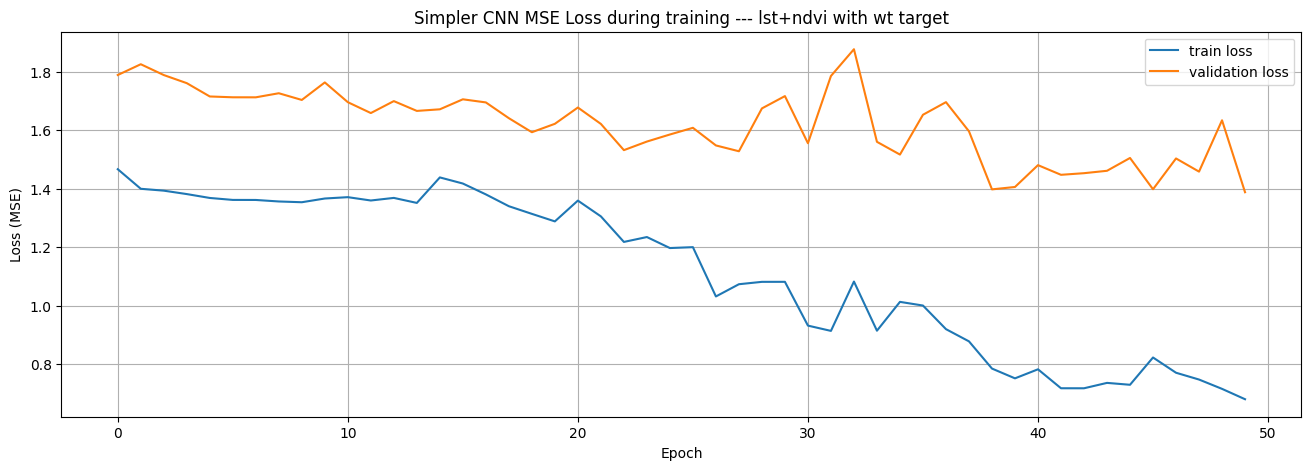

In [419]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

In [420]:
plt.savefig('../plots/cnn.png')

<Figure size 640x480 with 0 Axes>

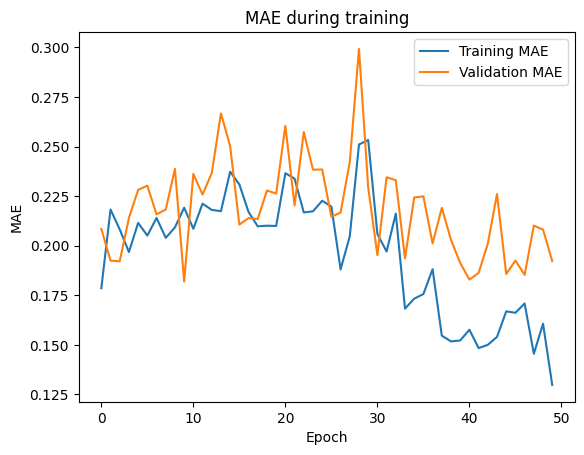

In [421]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Validate and test

In [422]:
# Evaluar el modelo en el conjunto de validación
loss, mae = simplified_cnn_model.evaluate(val_model_input, validation_target)

print(f'Pérdida (MSE) en validación: {loss}')
print(f'MAE en validación: {mae}')

1/1 [==============================] - 0s 54ms/step - loss: 1.3875 - mae: 0.1922
Pérdida (MSE) en validación: 1.3874971866607666
MAE en validación: 0.19224242866039276


In [423]:
validation_prediction = simplified_cnn_model.predict(val_model_input)
test_prediction = simplified_cnn_model.predict(test_model_input)

1/1 [==============================] - 0s 41ms/step


In [424]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

test_target_flat = test_target.reshape(-1)
test_prediction_flat = test_prediction.reshape(-1)

In [425]:
validation_target.shape

(11, 256, 256)

In [426]:
val_target_mask = validation_target_flat[validation_target_flat!= 0]
val_pred_mask = validation_prediction_flat[validation_target_flat!= 0]
test_target_mask = test_target_flat[test_target_flat!= 0]
test_pred_mask = test_prediction_flat[test_target_flat!= 0]

Overall results

In [427]:
results = evaluate_model(val_target_mask, val_pred_mask)
print('Validation results')
for k,v in results.items():
  print(k,':',v)

Validation results
MAE : 8.344411
MSE : 27.090273
RMSE : 9.179817
R² : -1.8253157599130625
MAPE (%) : 93.08115243911743
MSE sample-wise : 84.269035


In [428]:
results = evaluate_model(test_target_mask, test_pred_mask)
print('Test results')
for k,v in results.items():
  print(k,':',v)

Test results
MAE : 6.6538463
MSE : 122.33827
RMSE : 8.6468
R² : -0.39070239720556144
MAPE (%) : 439.5048141479492
MSE sample-wise : 74.76716


Image wise metrics results

In [429]:
test_prediction.shape

(11, 256, 256)

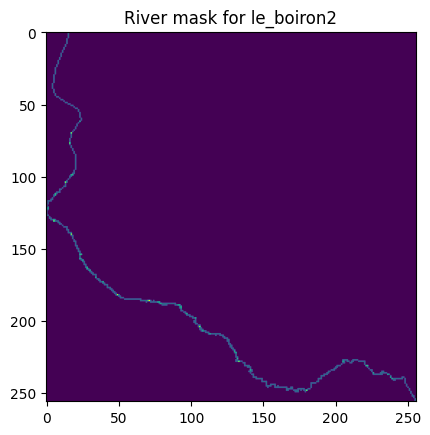

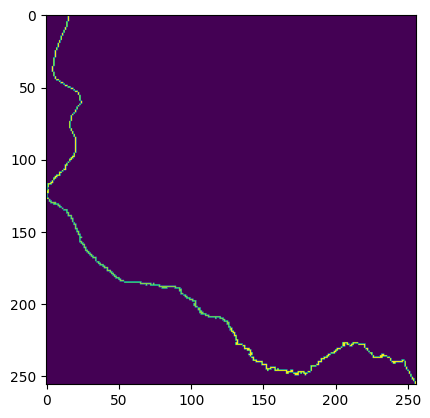

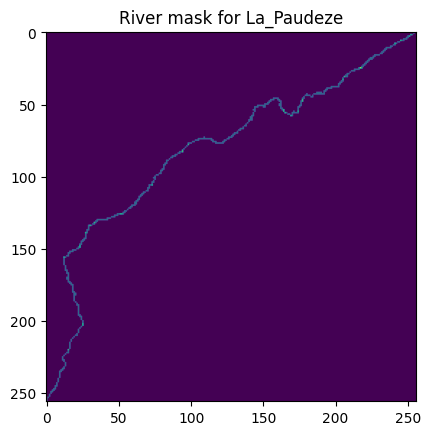

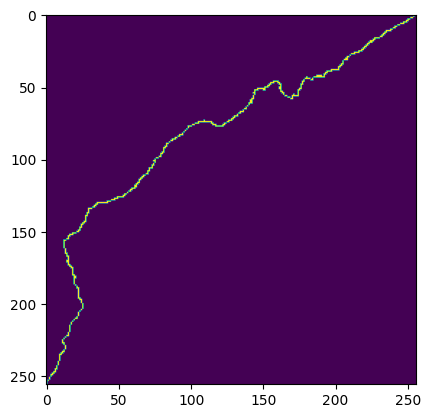

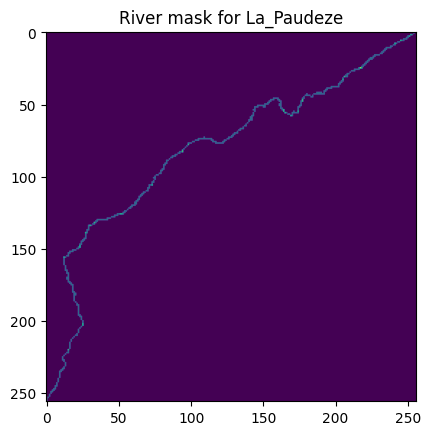

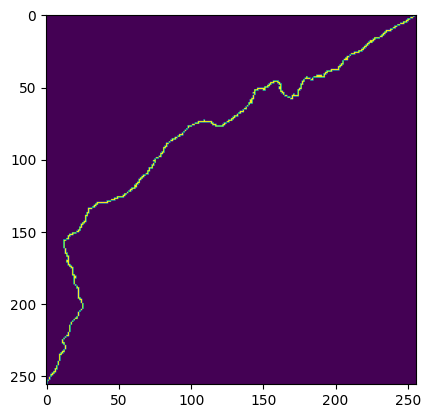

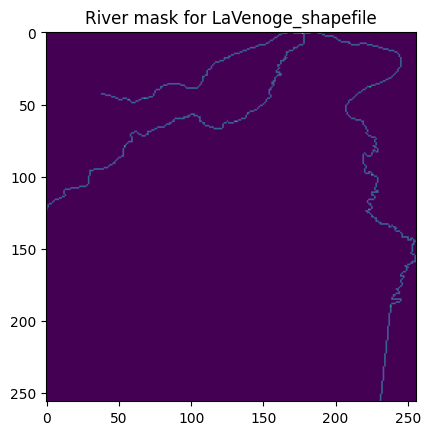

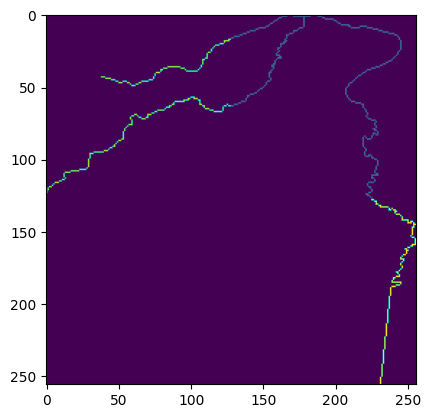

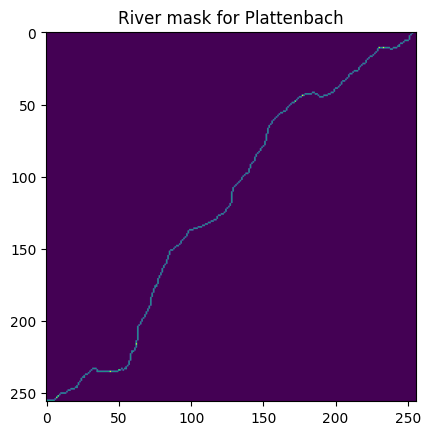

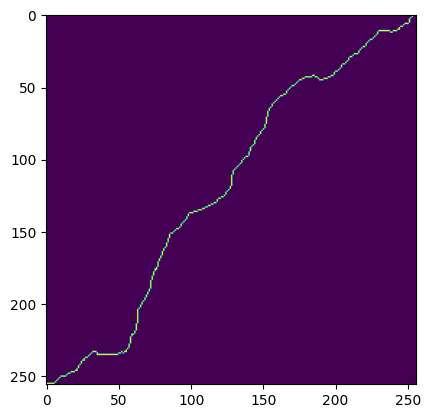

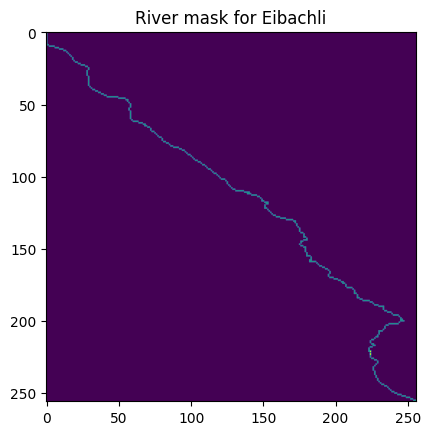

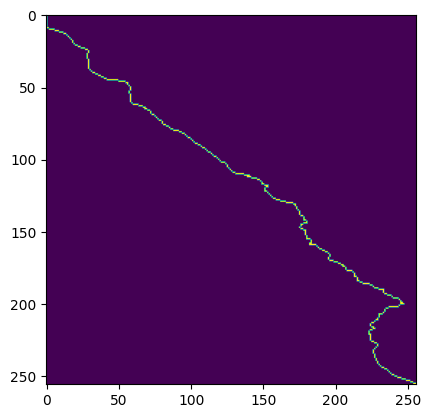

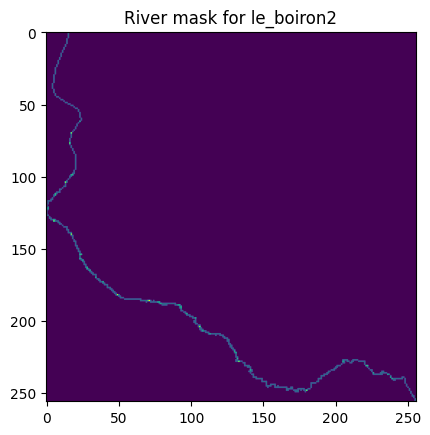

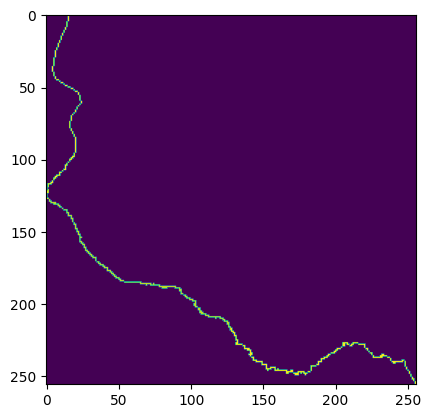

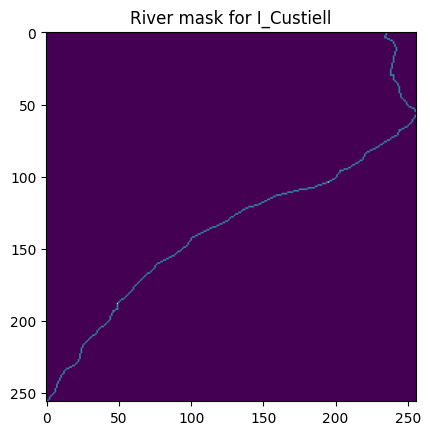

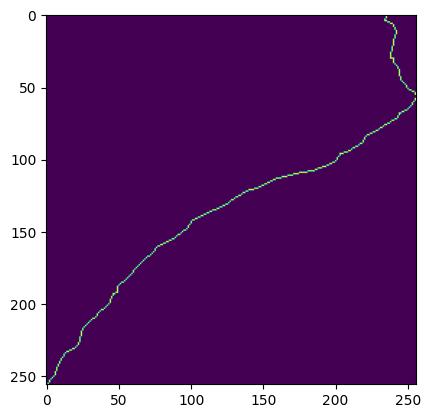

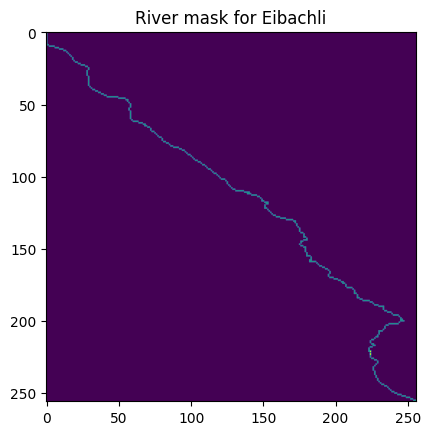

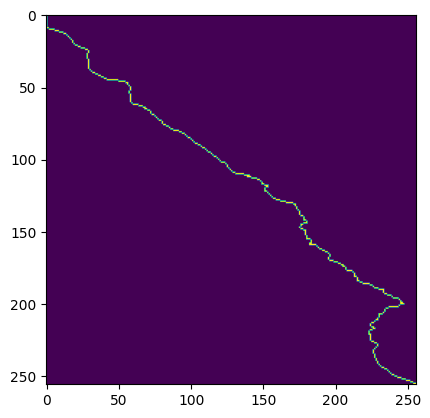

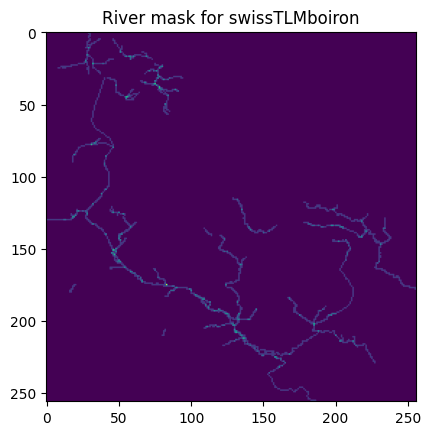

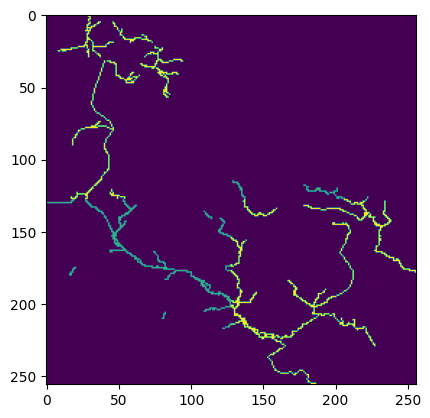

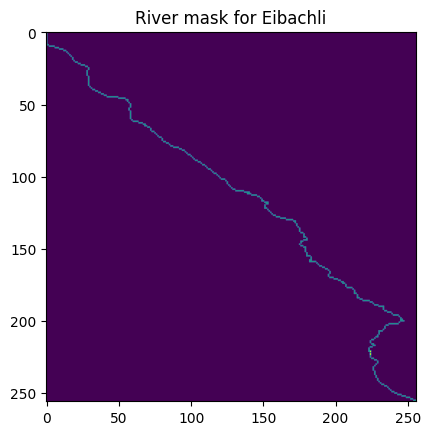

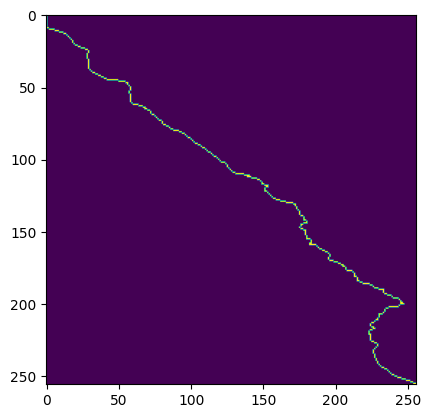


{'MAE': 6.558722, 'MSE': 70.76722, 'RMSE': 6.5843625, 'R²': -126900095179398.84, 'MAPE (%)': 333.55077342553574, 'MSE sample-wise': 73.63493}


In [430]:
mean_results = {k:[] for k in results.keys()}
# Loop through each sample and compute the MSE for that sample
for i in range(test_target.shape[0]):
    # Flatten the true and predicted values for this sample
    riv = rivers[labels[test_index[i]]].flatten()
    
    plt.imshow(rivers[labels[test_index[i]]])
    plt.title(f'River mask for {labels[test_index[i]]}')
    plt.show()

    plt.imshow(test_target[i])
    plt.show()
    print()

    y_true_flatten = test_target[i].flatten()
    y_true_mask = y_true_flatten[riv != 0]

    y_pred_flatten = test_prediction[i].flatten()
    y_pred_mask = y_pred_flatten[riv != 0]

    # Calculate MSE for this sample
    mse = mean_squared_error(y_true_mask, y_pred_mask)
    res = evaluate_model(y_true_mask, y_pred_mask)

    for k,v in res.items():
      mean_results[k].append(v)


for key in mean_results:
    mean_results[key] = np.mean(mean_results[key])

print(mean_results)

See what are the areas with more prediction error

In [431]:
validation_prediction[0].shape

(256, 256)

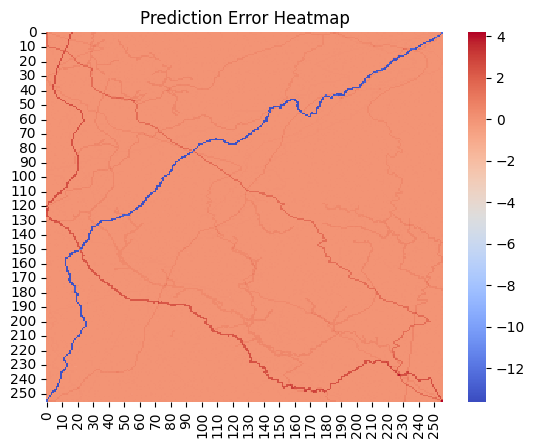

In [432]:
diff = validation_prediction[0] - validation_target[0]
sns.heatmap(diff, cmap='coolwarm')
plt.title('Prediction Error Heatmap')
plt.show()

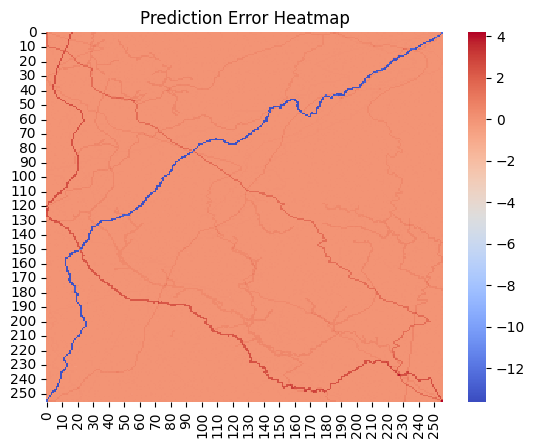

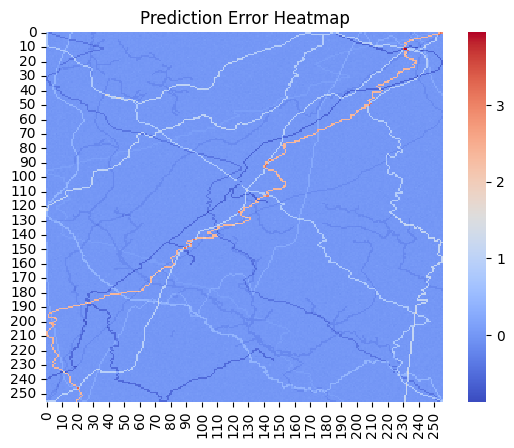

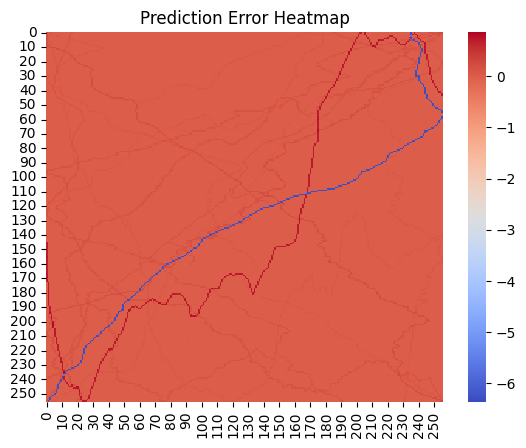

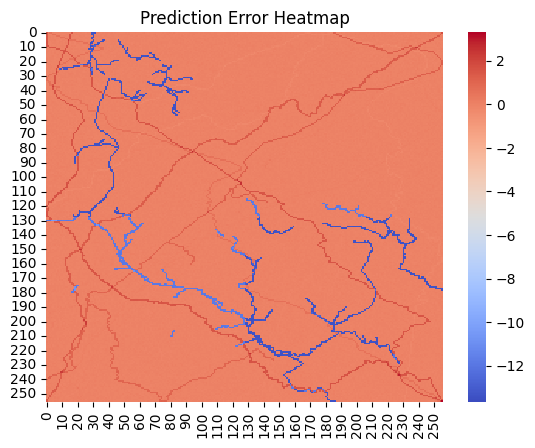

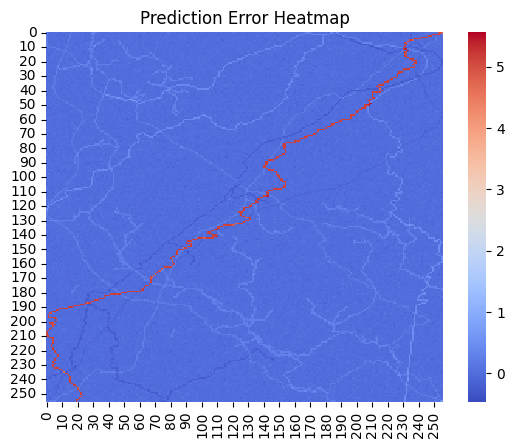

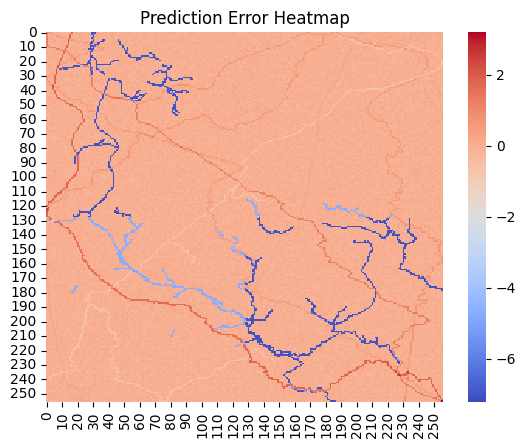

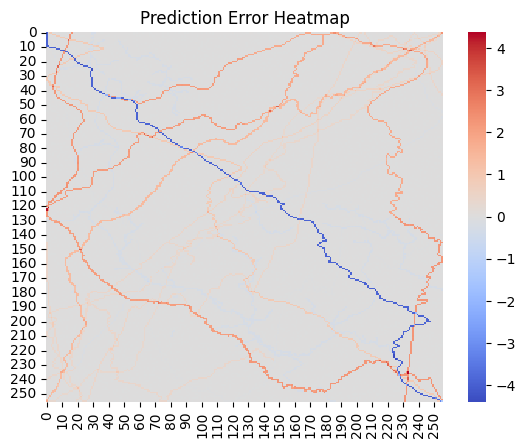

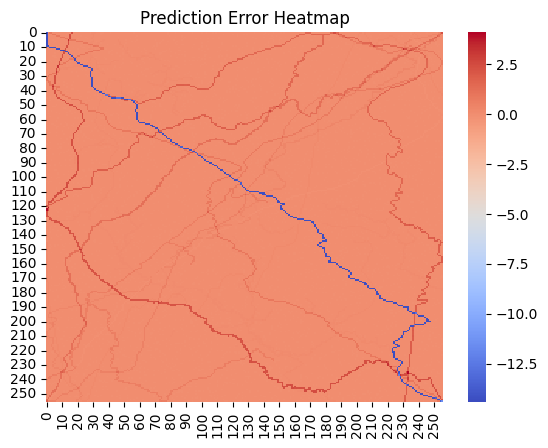

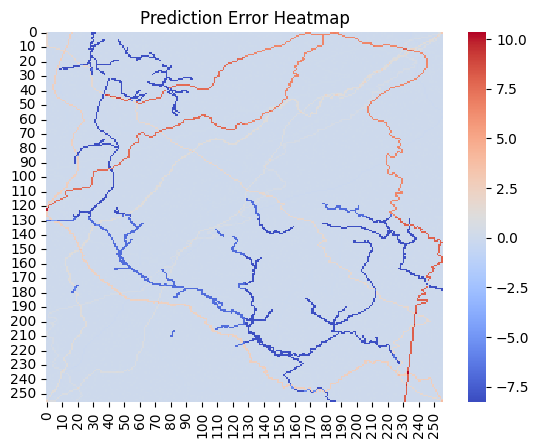

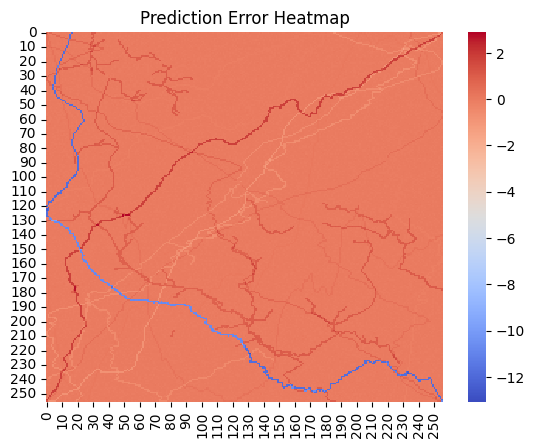

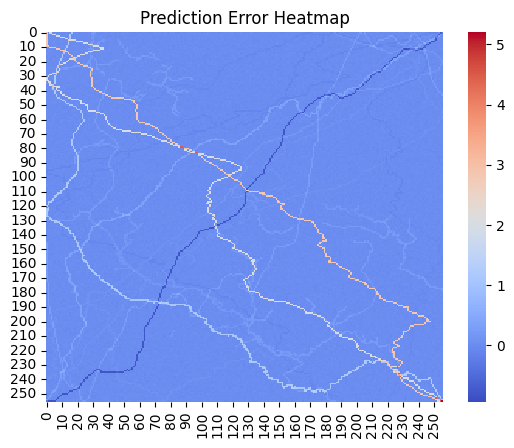

In [433]:
diff = validation_prediction - validation_target
for i in range(diff.shape[0]):
  sns.heatmap(diff[i], cmap='coolwarm')
  plt.title('Prediction Error Heatmap')
  plt.show()

Dispersion graph and histogram of prediction errors

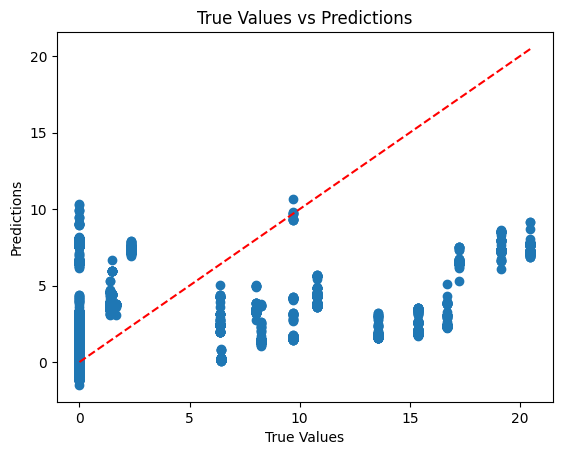

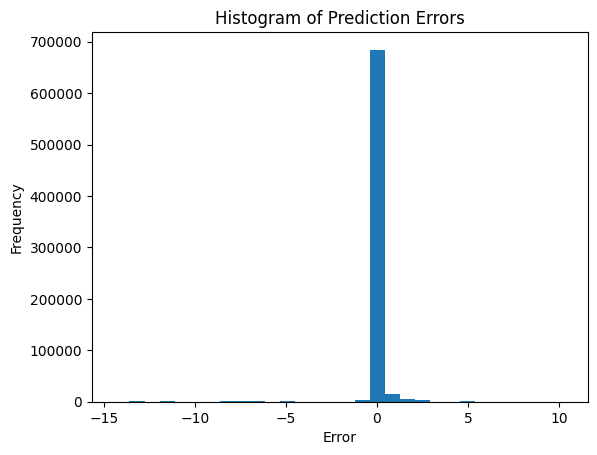

In [434]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que y_true son tus valores reales y y_pred son tus predicciones
y_true = validation_target_flat # Valores reales
y_pred = validation_prediction_flat  # Predicciones del modelo

# Visualización
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('True Values vs Predictions')
plt.show()

# Histograma de errores
errors = y_pred - y_true
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


#### Save model results

In [439]:
laabeel = 'label' if conditioned else 'no label'
variables = 'lst'+', '.join(inputs) + ', ' + laabeel


In [436]:
model_name = "img_wise_CNN"
details = {'RMSE':mean_results['RMSE'],'Variables':variables,'Input': f'{len(np.unique(labels))} rivers', 'Output': 'wt', 'Resolution': W, 'nº samples': len(data_targets), 'Batch size': batch_size, 'Epochs': epochs}

file_path = f"../results/{model_name}_results.xlsx"
save_excel(file_path, details, excel = 'Results')

mean_results['Model'] = model_name
file_path = f"../results/all_results.xlsx"
save_excel(file_path, mean_results, excel = 'Results')